This notebook examines the hard drive data collected from BackBlaze. https://www.backblaze.com/b2/hard-drive-test-data.html  BackBlaze is a cloud storage company that has made their hard drive data public.  The data was presumably obtained by using open source software like smartmontools (https://sourceforge.net/projects/smartmontools/). 
The data is collected daily for each hard drive and their respective S.M.A.R.T data counters.
First part of this notebook will examine the raw data received, then the data will be cleaned before running through


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble, metrics
from IPython.display import Image
from IPython.core.display import HTML 

In [19]:
# limit to first 1000 rows for now until doc is complete
hdd = pd.read_csv('../input/harddrive_resampled.csv') #,nrows = 10000)
hdd.head()

,serial_number,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_8_raw,smart_9_raw,...,smart_224_raw,smart_225_raw,smart_226_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_250_raw,smart_251_raw,smart_252_raw,smart_254_raw
0,30154,0,54551400,-1,0,4,0,1.279800e-317,-1,411,...,-1,-1,-1,1.319155e-321,3.467963e-315,1.316882e-315,-1,-1,-1,-1
1,2976,0,13985080,-1,0,3,0,1.017278e-315,-1,5506,...,-1,-1,-1,2.656097e-320,1.123662e-313,1.761059e-314,-1,-1,-1,-1
2,2975,0,109242152,-1,0,3,0,7.266557e-316,-1,4016,...,-1,-1,-1,1.830019e-320,9.029058e-314,2.551732e-314,-1,-1,-1,-1
3,21345,0,46112000,-1,0,16,0,1.488203e-315,-1,5130,...,-1,-1,-1,2.533569e-320,5.856105e-314,2.356922e-313,-1,-1,-1,-1
4,16688,0,117245752,-1,0,7,0,2.371728e-314,-1,10639,...,-1,-1,-1,5.188677e-320,8.240600e-314,6.064623e-313,-1,-1,-1,-1


In [20]:
# number of rows and columns in dataset
hdd.shape

(1681473, 45)

In [21]:
train_y = np.asarray(hdd['failure'])
if 1 in train_y:
    print ("Has failures")
else:
    print ("No failures")

Has failures


In [22]:

hdd.drop(['failure', 'serial_number'], inplace=True, axis=1)
hdd.columns
feat_names = hdd.columns.values
feat_names

array(['smart_1_raw', 'smart_2_raw', 'smart_3_raw', 'smart_4_raw',
       'smart_5_raw', 'smart_7_raw', 'smart_8_raw', 'smart_9_raw',
       'smart_10_raw', 'smart_11_raw', 'smart_12_raw', 'smart_13_raw',
       'smart_22_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_191_raw',
       'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_195_raw',
       'smart_196_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
       'smart_200_raw', 'smart_201_raw', 'smart_220_raw', 'smart_222_raw',
       'smart_223_raw', 'smart_224_raw', 'smart_225_raw', 'smart_226_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_250_raw',
       'smart_251_raw', 'smart_252_raw', 'smart_254_raw'], dtype=object)

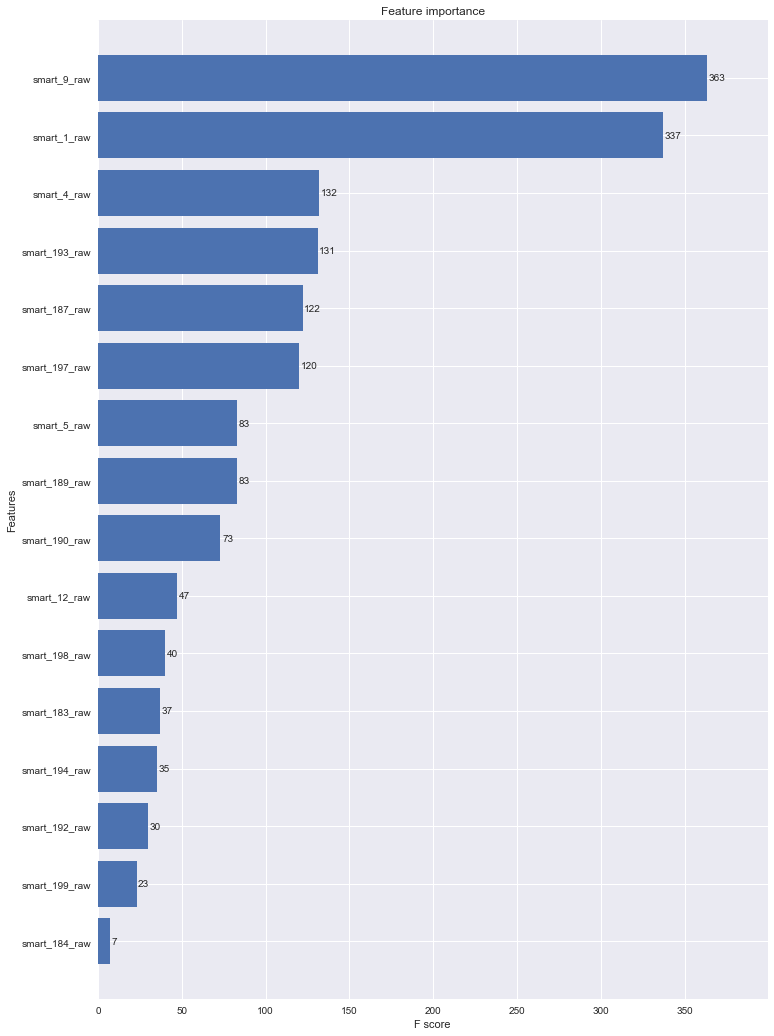

In [23]:


#from sklearn import ensemble
#model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
#model.fit(train_df, train_y)

## plot the importances ##
#importances = model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
#indices = np.argsort(importances)[::-1][:20]

#plt.figure(figsize=(12,12))
#plt.title("Feature importances")
#plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
#plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
#plt.xlim([-1, len(indices)])
#plt.show()
#'''

import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(hdd, train_y, feature_names=hdd.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


# Feature Importance


Running XGBoost estimator, the following features were the only ones listed (in order of importance)

Smart 9
Smart 1
Smart 197
Smart 187
Smart 4
Smart 193
Smart 198
Smart 190
Smart 189 
Smart 5
Smart 12
Smart 199
Smart 194
Smart 192
Smart 183
Smart 184

### Feature Engineering
Note: May want to try including the following:

S.M.A.R.T. 9 is the number of hours a drive has been in service. To calculate a drive's age in days, divide this number by 24.

In [24]:
from sklearn.ensemble import RandomForestRegressor

# try random forrest feature importance
#rf = ensemble.RandomForestClassifier()
#rf.fit(hdd, train_y)
# get rankings of feature importance
#preds = rf.predict_proba(test)
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=1)
rf.fit(hdd, train_y)
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feat_names), reverse=True)
#ranks = ranking(rf.feature_importances_, feat_names)

# Put the mean scores into a Pandas dataframe
#meanplot = pd.DataFrame(ranks.items(), columns= ['Feature','Ranking'])

# Sort the dataframe
#meanplot = meanplot.sort_values('Ranking', ascending=False)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min


[(0.263, 'smart_9_raw'), (0.2168, 'smart_1_raw'), (0.1611, 'smart_193_raw'), (0.0503, 'smart_187_raw'), (0.0448, 'smart_189_raw'), (0.0443, 'smart_198_raw'), (0.0348, 'smart_194_raw'), (0.0342, 'smart_190_raw'), (0.0291, 'smart_197_raw'), (0.0283, 'smart_4_raw'), (0.0253, 'smart_12_raw'), (0.0241, 'smart_192_raw'), (0.0166, 'smart_5_raw'), (0.0148, 'smart_199_raw'), (0.0124, 'smart_183_raw'), (0.0003, 'smart_184_raw'), (0.0, 'smart_8_raw'), (0.0, 'smart_7_raw'), (0.0, 'smart_3_raw'), (0.0, 'smart_2_raw'), (0.0, 'smart_254_raw'), (0.0, 'smart_252_raw'), (0.0, 'smart_251_raw'), (0.0, 'smart_250_raw'), (0.0, 'smart_242_raw'), (0.0, 'smart_241_raw'), (0.0, 'smart_240_raw'), (0.0, 'smart_22_raw'), (0.0, 'smart_226_raw'), (0.0, 'smart_225_raw'), (0.0, 'smart_224_raw'), (0.0, 'smart_223_raw'), (0.0, 'smart_222_raw'), (0.0, 'smart_220_raw'), (0.0, 'smart_201_raw'), (0.0, 'smart_200_raw'), (0.0, 'smart_196_raw'), (0.0, 'smart_195_raw'), (0.0, 'smart_191_raw'), (0.0, 'smart_188_raw'), (0.0, 'sma

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


In [25]:
use_columns = ['smart_5_raw', 'smart_11_raw', 'smart_187_raw', 'smart_189_raw', \
               'smart_196_raw', 'smart_197_raw', 'smart_198_raw']

columns_to_drop =['smart_2_raw', 'smart_3_raw', 'smart_7_raw', 'smart_8_raw', 'smart_11_raw', 'smart_192_raw',  'smart_195_raw', 
    'smart_199_raw', 'smart_200_raw', 'smart_220_raw', 'smart_222_raw', 'smart_223_raw',  'smart_191_raw',
    'smart_224_raw',  'smart_225_raw', 'smart_226_raw', 'smart_240_raw',  'smart_241_raw', 
    'smart_242_raw',  'smart_250_raw', 'smart_251_raw',  'smart_252_raw',  'smart_254_raw',
    'smart_22_raw', 'smart_188_raw']


In [26]:
hdd.drop(columns_to_drop, inplace=True, axis=1)
hdd.columns

Index([u'smart_1_raw', u'smart_4_raw', u'smart_5_raw', u'smart_9_raw',
       u'smart_10_raw', u'smart_12_raw', u'smart_13_raw', u'smart_183_raw',
       u'smart_184_raw', u'smart_187_raw', u'smart_189_raw', u'smart_190_raw',
       u'smart_193_raw', u'smart_194_raw', u'smart_196_raw', u'smart_197_raw',
       u'smart_198_raw', u'smart_201_raw'],
      dtype='object')

Don't really want to drop some of those columns like smart_10_raw -- 

In [27]:
hdd.shape

(1681473, 18)

In [28]:
# based on above need to drop some more columns -- moving up in notebook- for better graph
columns_to_drop =['smart_10_raw', 'smart_13_raw', 'smart_196_raw', 'smart_201_raw']
hdd.drop(columns_to_drop, inplace=True, axis=1)
hdd.columns

Index([u'smart_1_raw', u'smart_4_raw', u'smart_5_raw', u'smart_9_raw',
       u'smart_12_raw', u'smart_183_raw', u'smart_184_raw', u'smart_187_raw',
       u'smart_189_raw', u'smart_190_raw', u'smart_193_raw', u'smart_194_raw',
       u'smart_197_raw', u'smart_198_raw'],
      dtype='object')

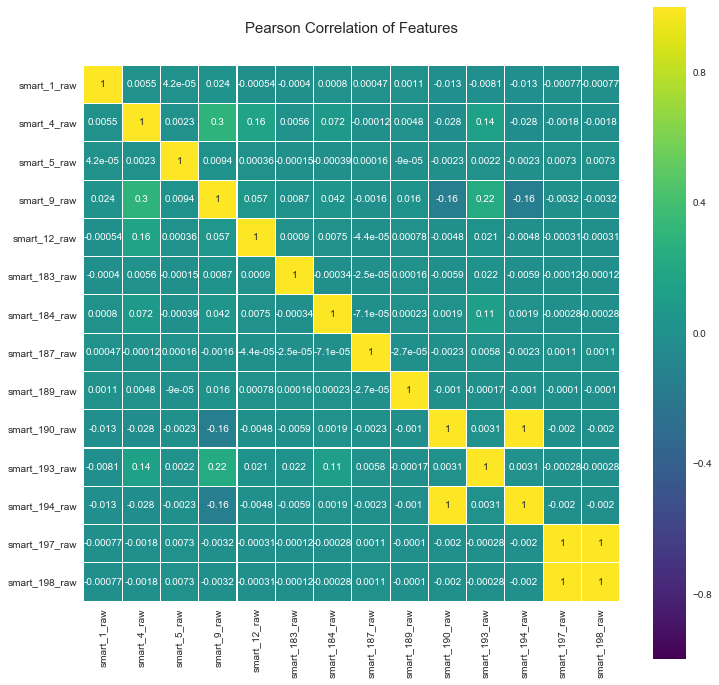

In [29]:
feats_df = pd.DataFrame()
feats_df = hdd
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(feats_df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)